In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scan import Scan
from receipt import Receipt
from read import read_receipts
import plotly as go

file_path = 'supermarket.csv'
receipts = read_receipts(file_path)
print(len(receipts))
print(receipts.total_[0:5]

total_scans = sum(len(receipt.scans) for receipt in receipts)
print(total_scans)


ModuleNotFoundError: No module named 'pandas'

We read in AHA supermarket transaction data. The goal is to identify high-risk fraud cases. There are 100,000 receipts and 2.2 million scans in the dataset. 

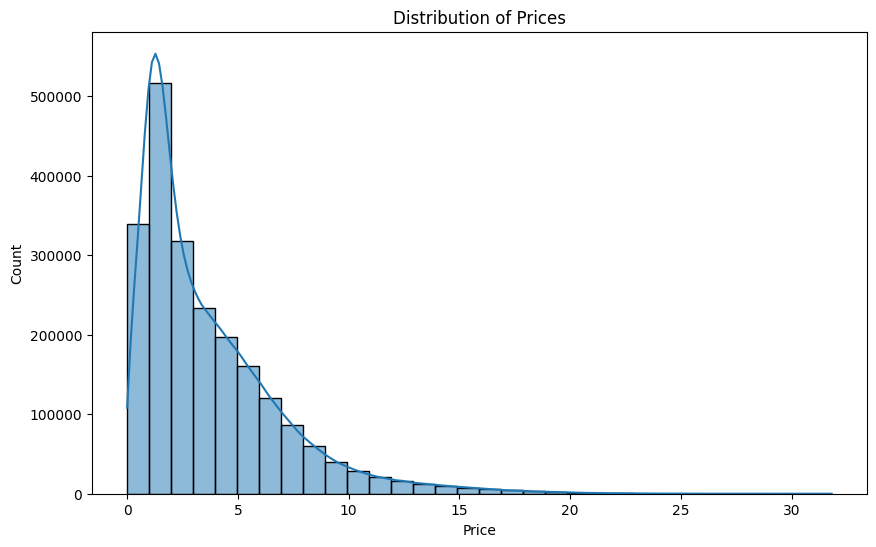

In [ ]:

scans = [] 
for receipt in receipts: 
    for scan in receipt.scans: 
        scans.append([scan.department, scan.time, scan.price])

scans_df = pd.DataFrame(scans, columns = ['Department', 'Time', 'Price'])    

plt.figure(figsize=(10, 6))
sns.histplot(data=scans_df, x='Price', kde=True, binwidth = 1)
plt.title('Distribution of Prices')
plt.show()


It appears that customers buy a lot of products that are less than 5 Euro. 

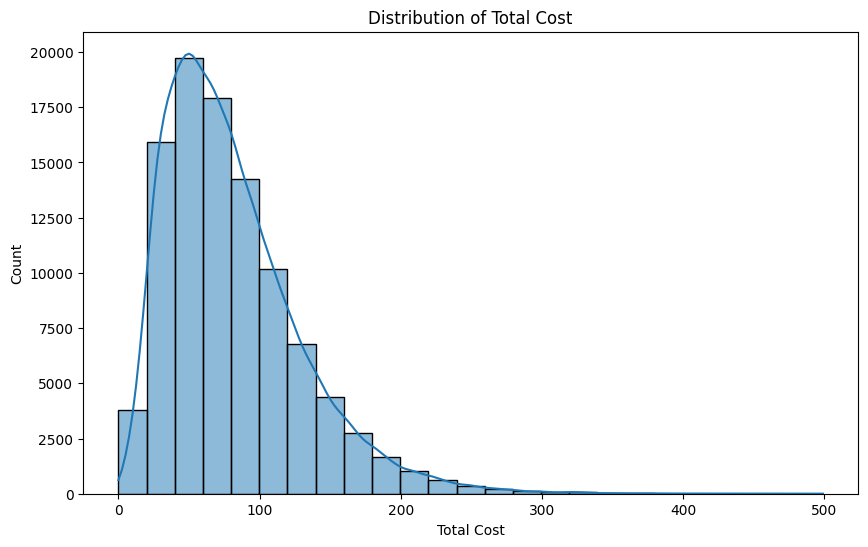

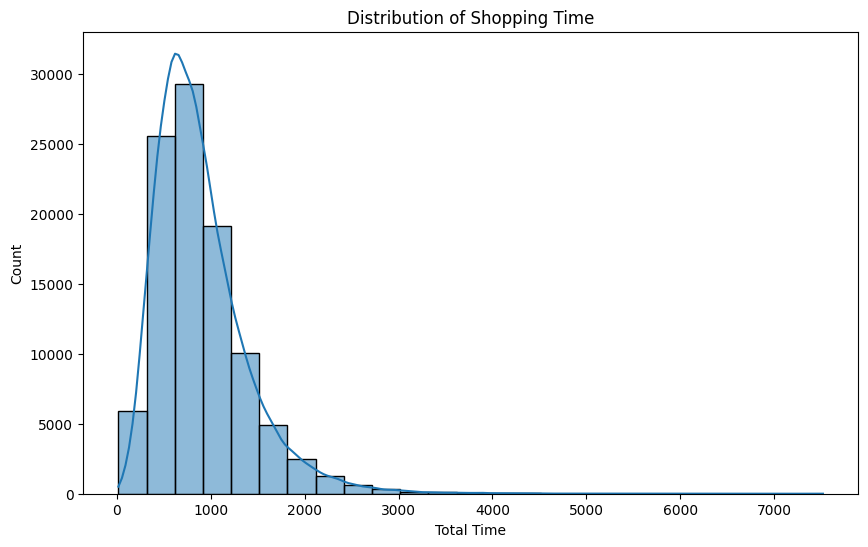

In [ ]:

receipt_data = []
for receipt in receipts: 
    receipt_data.append([receipt.total_time, receipt.total_cost])

receipt_data_df = pd.DataFrame(receipt_data, columns=['Total Time','Total Cost'])

plt.figure(figsize=(10, 6))
sns.histplot(data=receipt_data_df, x='Total Cost', kde=True, binwidth = 20)
plt.title('Distribution of Total Cost')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=receipt_data_df, x='Total Time', kde=True, binwidth = 300)
plt.title('Distribution of Shopping Time')
plt.show()



Considering the bin width, the majority of customers spend 10~20 minutes per an AHA visit. 
 Furthermore, the median budget appears to be 40~60 Euro, which reflects everyday grocery experience.

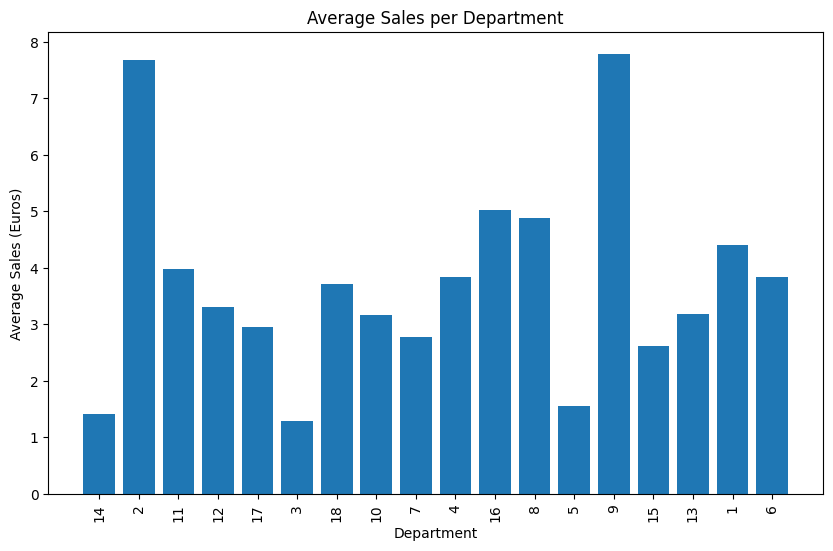

In [ ]:
sales_per_department = scans_df.groupby('Department')['Price'].sum().reset_index()
count_per_department = scans_df.groupby('Department')['Price'].count().reset_index()

avg_sales_per_department = sales_per_department.merge(count_per_department, on='Department')
avg_sales_per_department['Avg_Sales'] = avg_sales_per_department['Price_x'] / avg_sales_per_department['Price_y']
avg_sales_per_department = avg_sales_per_department.sort_values(by='Avg_Sales', ascending=False)

# plot suggested by ChatGPT 
plt.figure(figsize=(10, 6))
plt.bar(avg_sales_per_department['Department'], avg_sales_per_department['Avg_Sales'])
plt.xlabel('Department')
plt.ylabel('Average Sales (Euros)')
plt.title('Average Sales per Department')
plt.xticks(rotation=90, ticks=range(1, len(avg_sales_per_department['Department'])+1), labels=avg_sales_per_department['Department'])

plt.show()

People go cheap at department 3, 5, and 14. 

1075176


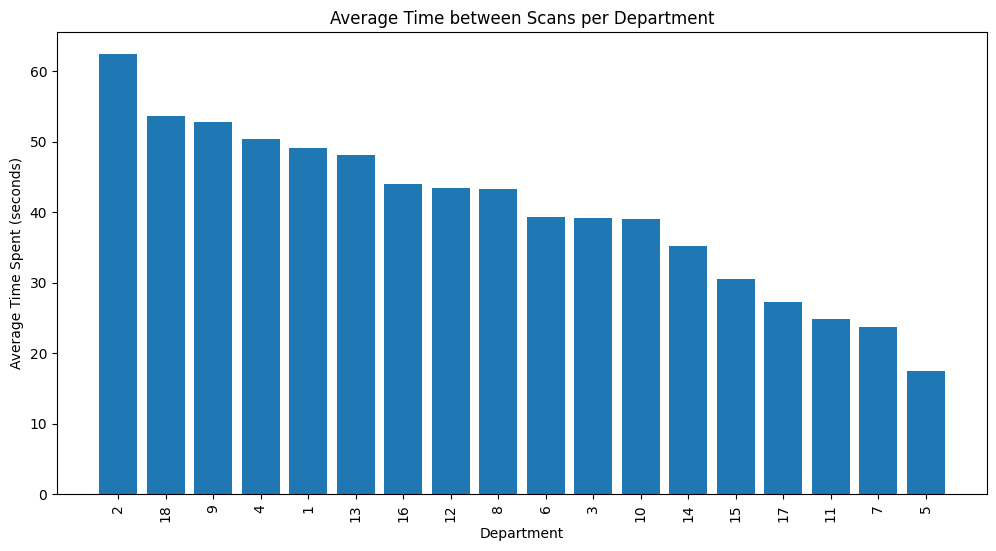

In [ ]:
# lagged variable
scans_df['PrevDept'] = scans_df['Department'].shift(1)
same_dept_scans = scans_df['Department'] == scans_df['PrevDept']
same_debt_scans_df = scans_df[same_dept_scans]
print(len(same_debt_scans_df))

same_dept_time = same_debt_scans_df.groupby('Department')['Time'].sum().reset_index()
same_dept_count = same_debt_scans_df.groupby('Department')['Time'].count().reset_index()

same_dept_time = same_dept_time.merge(same_dept_count, on='Department')
same_dept_time['Avg_Time'] = same_dept_time['Time_x'] / same_dept_time['Time_y']

same_dept_time = same_dept_time.sort_values(by='Avg_Time', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(range(len(same_dept_time)), same_dept_time['Avg_Time'])
plt.xlabel('Department')
plt.ylabel('Average Time Spent (seconds)')
plt.title('Average Time between Scans per Department')
plt.xticks(range(len(same_dept_time)), same_dept_time['Department'], rotation=90)
plt.show()   

2184956


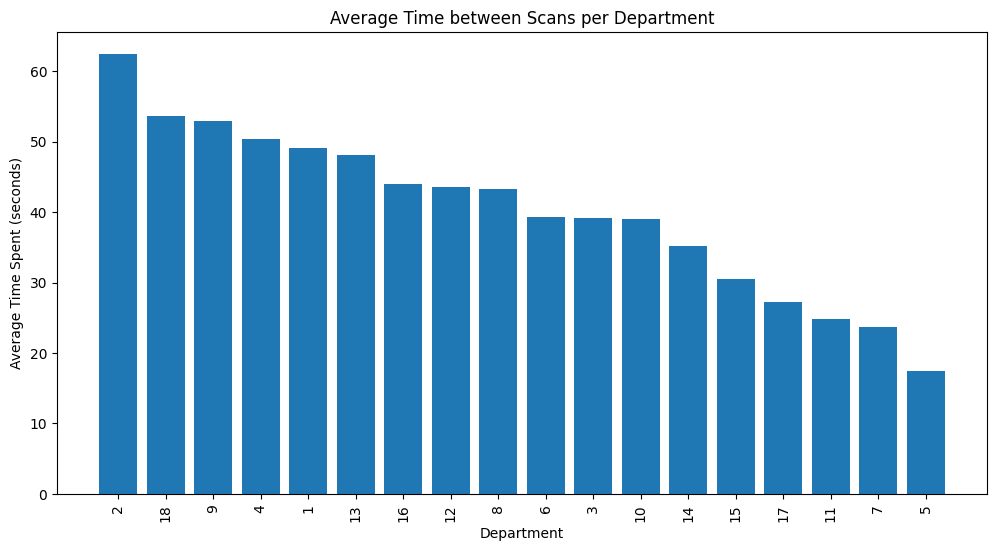

In [ ]:
print(len(scans_df))
dept_time = scans_df.groupby('Department')['Time'].sum().reset_index() 
dept_count = scans_df.groupby('Department')['Time'].count().reset_index() 
dept_time = dept_time.merge(dept_count, on='Department') 
dept_time['Avg_Time'] = dept_time['Time_x'] / dept_time['Time_y'] 
dept_time = dept_time.sort_values(by='Avg_Time', ascending=False) 
plt.figure(figsize=(12, 6)) 
plt.bar(range(len(dept_time)), dept_time['Avg_Time']) 
plt.xlabel('Department') 
plt.ylabel('Average Time Spent (seconds)') 
plt.title('Average Time between Scans per Department') 
plt.xticks(range(len(dept_time)), dept_time['Department'], rotation=90) 
plt.show()

In [1]:
from collections import defaultdict

department_associations = defaultdict(list)

for receipt in receipts:
    departments = [scan.department for scan in receipt.scans]
    department_associations[frozenset(departments)].append(1)

for key in department_associations:
    department_associations[key] = sum(department_associations[key])

sorted_associations = sorted(department_associations.items(), key=lambda x: x[1], reverse=True)

# Display the most common department associations
for departments, count in sorted_associations[:10]:  # Adjust slice for more or fewer results
    print(f"Departments {set(departments)} appear together in {count} receipts")

labels = [', '.join(map(str, dept)) for dept, _ in sorted_associations[:10]]
counts = [count for _, count in sorted_associations[:10]]

# Create bar chart
plt.figure(figsize=(10, 8))
plt.barh(labels, counts, color='skyblue')
plt.xlabel('Frequency of Department Association')
plt.ylabel('Departments')
plt.title('Top 10 Common Department Associations in Receipts')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top

plt.show()

Some departments are really strongly associated, with 0.4% support. We can employ downward-closure property to explore further.

In [ ]:
sorted_dept_spending = sorted(dept_spending.items(), key=lambda x: x[1], reverse=True)

# Extract department names and spending amounts
dept_names = [dept for dept, spend in sorted_dept_spending]
spending_amounts = [spend for dept, spend in sorted_dept_spending]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dept_names, spending_amounts)
ax.set_xlabel('Department', fontsize=12)
ax.set_ylabel('Spending Amount', fontsize=12)
ax.set_title('Department Spending', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'dept_spending' is not defined

We can think about percentage spending per department per receipts

In [ ]:
dept_avg_time = defaultdict(float)
dept_visit_count = defaultdict(int)

for receipt in receipts:
    for scan in receipt.scans:
        dept = scan.department
        dept_avg_time[dept] += scan.time
        dept_visit_count[dept] += 1

for dept, total_time in dept_avg_time.items():
    avg_time = total_time / dept_visit_count[dept]
    print(f"Average time spent in department {dept}: {avg_time:.2f} seconds")
    
departments = list(dept_avg_time.keys())
avg_times = [dept_avg_time[dept] / dept_visit_count[dept] for dept in departments]

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(departments, avg_times)
ax.set_xlabel('Department', fontsize=12)
ax.set_ylabel('Average Time (seconds)', fontsize=12)
ax.set_title('Average Time Spent in Each Department', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()
plt.show()

We can think about time spent per department, as well as measure standard deviation of time spent per department. Big SD on time spent might be sus.

In [3]:
def modify_sequences(receipts, department_locations):
    modified_sequences = []
    for receipt in receipts:
        dept_sequence = [20] + [scan.department for scan in receipt.scans] + [19]
        modified_sequences.append(dept_sequence)
    return modified_sequences

department_locations = {
    1: [0.4, 0.2],
    2: [0.4, 0.01],
    3: [0.1, 0.01],
    4: [0.2, 0.1],
    5: [0.2, 0.01],
    6: [0.01, 0.1],
    7: [0.3, 0.2],
    8: [0.01, 0.2],
    9: [0.4, 0.1],
    10: [0.1, 0.3],
    11: [0.3, 0.01],
    12: [0.4, 0.3],
    13: [0.2, 0.2],
    14: [0.2, 0.3],
    15: [0.1, 0.2],
    16: [0.3, 0.1],
    17: [0.1, 0.1],
    18: [0.3, 0.3],
    19: [0.01, 0.01],
    20: [0.01, 0.3]
}

modified_sequences = modify_sequences(receipts, department_locations)

dept_sequences = defaultdict(list)
for sequence in modified_sequences:
    dept_sequences[len(sequence)].append(sequence)

top_sequences = dept_sequences[10]  
labels = list(set([dept for sequence in top_sequences for dept in sequence]))
source_target_pairs = [(labels.index(seq[i]), labels.index(seq[i+1])) for seq in top_sequences for i in range(len(seq)-1)]

data = go.Sankey(
    node=dict(
        label=labels,
        color="blue"
    ),
    link=dict(
        source=[item[0] for item in source_target_pairs],
        target=[item[1] for item in source_target_pairs],
        value=[1] * len(source_target_pairs)  # Adjust the value based on your data
    )
)

fig = go.Figure(data)
fig.update_layout(title="Customer Traffic Flow")
fig.show()

NameError: name 'receipts' is not defined

Common path traffic

In [ ]:
import plotly.graph_objects as go
from collections import defaultdict

def modify_sequences(receipts, department_locations):
    modified_sequences = []
    for receipt in receipts:
        dept_sequence = [20] + [scan.department for scan in receipt.scans] + [19]
        modified_sequences.append(dept_sequence)
    return modified_sequences

department_locations = {
    1: [0.4, 0.2],
    2: [0.4, 0.01],
    3: [0.1, 0.01],
    4: [0.2, 0.1],
    5: [0.2, 0.01],
    6: [0.01, 0.1],
    7: [0.3, 0.2],
    8: [0.01, 0.2],
    9: [0.4, 0.1],
    10: [0.1, 0.3],
    11: [0.3, 0.01],
    12: [0.4, 0.3],
    13: [0.2, 0.2],
    14: [0.2, 0.3],
    15: [0.1, 0.2],
    16: [0.3, 0.1],
    17: [0.1, 0.1],
    18: [0.3, 0.3],
    19: [0.01, 0.01],
    20: [0.01, 0.3]
}

modified_sequences = modify_sequences(receipts, department_locations)

dept_sequences = defaultdict(list)
for sequence in modified_sequences:
    dept_sequences[len(sequence)].append(sequence)

top_sequences = dept_sequences[6]  # For sequences of length 6 (including check-in and checkout)

# Create a list of unique department indices
labels = list(set([dept for sequence in top_sequences for dept in sequence]))

# Create source, target, and value lists for the Sankey diagram
source_target_pairs = [(labels.index(seq[i]), labels.index(seq[i+1])) for seq in top_sequences for i in range(len(seq)-1)]

# Define grid coordinates for node positioning
grid_x = {dept_location[0]: x for x, dept_location in enumerate(sorted(department_locations.values(), key=lambda x: x[0]))}
grid_y = {dept_location[1]: y for y, dept_location in enumerate(sorted(department_locations.values(), key=lambda x: x[1], reverse=True))}

data = go.Sankey(
    node=dict(
        label=[list(department_locations.keys())[idx] for idx in labels],
        x=[grid_x[department_locations[list(department_locations.keys())[idx]][0]] for idx in labels],
        y=[grid_y[department_locations[list(department_locations.keys())[idx]][1]] for idx in labels],
        color="blue"
    ),
    link=dict(
        source=[item[0] for item in source_target_pairs],
        target=[item[1] for item in source_target_pairs],
        value=[1] * len(source_target_pairs)  # Adjust the value based on your data
    )
)

fig = go.Figure(data)
fig.update_layout(title="Customer Traffic Flow")
fig.show()


IndexError: list index out of range

In [ ]:
import plotly.graph_objects as go
from collections import defaultdict, Counter

def draw_paths(sequences, department_locations):
    # Create a mapping of department names to their coordinates
    dept_coords = department_locations

    # Create a list of unique department indices that are present in dept_coords
    valid_indices = [i for i, dept in enumerate(dept_coords.keys())]

    # Filter out sequences that contain invalid department indices
    valid_sequences = [seq for seq in sequences if all(idx in valid_indices for idx in seq)]

    # Create a list of unique department indices
    labels = list(set([idx for sequence in valid_sequences for idx in sequence]))

    # Count the occurrences of each source-target pair
    path_counts = defaultdict(int)
    for seq in valid_sequences:
        for i in range(len(seq) - 1):
            source = seq[i]
            target = seq[i + 1]
            path_counts[(source, target)] += 1

    # Define grid coordinates for department locations
    grid_x = {0: 0, 1: 2, 2: 4, 3: 6, 4: 8}
    grid_y = {0: 0, 1: 2, 2: 4, 3: 6}

    # Create traces for nodes and links
    node_trace = go.Sankey(
        node=dict(
            label=[list(dept_coords.keys())[idx] for idx in labels],
            x=[grid_x[dept_coords[list(dept_coords.keys())[idx]][0]] for idx in labels],
            y=[grid_y[dept_coords[list(dept_coords.keys())[idx]][1]] for idx in labels],
            color="blue"
        )
    )

    link_data = []
    for (source, target), count in path_counts.items():
        source_coords = dept_coords[list(dept_coords.keys())[source]]
        target_coords = dept_coords[list(dept_coords.keys())[target]]
        source_x = grid_x[source_coords[0]]
        source_y = grid_y[source_coords[1]]
        target_x = grid_x[target_coords[0]]
        target_y = grid_y[target_coords[1]]
        link_data.append(go.Scatter(
            x=[source_x, target_x, None],
            y=[source_y, target_y, None],
            mode='lines',
            line=dict(width=count * 0.1, color='red'),
            hovertext=f"From {list(dept_coords.keys())[source]} to {list(dept_coords.keys())[target]}: {count} visits"
        ))

    # Create a figure with the node trace and link traces
    fig = go.Figure(data=[node_trace] + link_data)
    fig.update_layout(title='Customer Traffic Flow', showlegend=False)
    fig.show()

# Call the function with your data
draw_paths(top_sequences, department_locations)

KeyError: 0.4

In [ ]:
department_locations = {
    1 : [0.4, 0.2],
    2: [0.4, 0.01],
    3: [0.1, 0.01], 
    4: [0.2, 0.1],
    5: [0.2, 0.01],
    6: [0.01, 0.1],
    7: [0.3, 0.2],
    8: [0.01, 0.2],
    9: [0.4, 0.1],
    10: [0.1, 0.3],
    11: [0.3, 0.01],
    12: [0.4, 0.3],
    13: [0.2, 0.2],
    14: [0.2, 0.3],
    15: [0.1, 0.2],
    16: [0.3, 0.1],
    17: [0.1, 0.1],
    18: [0.3, 0.3],
    19: [0.01, 0.01],
    20: [0.01, 0.3]
}


dept_sequences = defaultdict(lambda: defaultdict(int))

for receipt in receipts:
    dept_sequence = [scan.department for scan in receipt.scans]
    for i in range(len(dept_sequence)-1):
        source = dept_sequence[i]
        target = dept_sequence[i+1]
        dept_sequences[len(dept_sequence)][source, target] += 1

top_sequences = [seq for seq, count in dept_sequences[5].items() if count > 1]

labels = list(set([dept for sequence in top_sequences for dept in sequence]))
source_target_pairs = [(labels.index(seq[i]), labels.index(seq[i+1]), count) 
                       for seq, count in dept_sequences[5].items()
                       for i in range(len(seq)-1)]

# Create a mapping of department indices to their coordinates
dept_coords = department_locations

data = go.Sankey(
    node=dict(
        label=[list(dept_coords.keys())[idx] for idx in labels],
        x=[dept_coords[list(dept_coords.keys())[idx]][0] for idx in labels],
        y=[dept_coords[list(dept_coords.keys())[idx]][1] for idx in labels],
        color="blue"
    ),
    link=dict(
        source=[item[0] for item in source_target_pairs],
        target=[item[1] for item in source_target_pairs],
        value=[item[2] for item in source_target_pairs],
        color="red"
    )
)

fig = go.Figure(data)
fig.update_layout(title="Customer Traffic Flow")
fig.show()

We can create plots on how customers move and what are the frequent paths